## Automated Surface Event Detection from Seismograms
Author: Akash Kharita
    
This notebook demonstrates how to use my machine learning model to detect surface events (snow avalanches/rockfalls/debris flows) through continuous seismograms from multiple station. We will take examples of verified events and see how my model/detector behaves around the event. 


Feel free to run this model on the starttimes and durations you would like!

## Importing dependencies


In [1]:
import pandas as pd
import numpy as np
import ast
import re


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
# import time
import random
import os
import sys
from datetime import datetime
from tqdm import tqdm

from scipy import stats,signal


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset


import numpy as np
import scipy.signal as signal

from matplotlib import lines as mlines

import sys
sys.path.append('../src')
from utils import apply_cosine_taper, butterworth_filter, resample_array


import numpy as np
import torch
import torch.nn.functional as F
from obspy import UTCDateTime, Stream
from obspy.clients.fdsn import Client
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import pickle
from joblib import dump, load


import os
# Specify the directory containing the module
module_path = os.path.abspath(os.path.join('..', 'src'))

# Add the directory to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)

import seis_feature
from utils import apply_cosine_taper, butterworth_filter, resample_array
 

from deep_learning_architectures import MyCNN_1d
from deep_learning_architectures import MyCNN_2d
from deep_learning_architectures import SeismicCNN_2d
from deep_learning_architectures import MyResCNN2D

import matplotlib.lines as mlines
import json


from zenodo_get import zenodo_get
doi = '10.5281/zenodo.13334838'
files = zenodo_get([doi])



from all_models_classification import compute_window_probs
from all_models_classification import plot_z_component_with_probs
from all_models_classification import plot_all_model_predictions
from all_models_classification import plot_single_station_probs

Title: Trained Random Forest Model and Scaler Parameters for (Phy+Man), 15 August, 2024
Keywords: 
Publication date: 2024-08-15
DOI: 10.5281/zenodo.13334838
Total size: 787.9 MB

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib   size: 191.0 MB

Checksum is correct. (7398572baf267d603e53e0203340cc8f)

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_30_F_05_15_50.csv   size: 0.0 MB
scaler_params_phy_man_P_10_30_F_05_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_100_F_05_15_50.csv   size: 0.0 MB
scaler_params_phy_man_P_10_100_F_05_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib   size: 196.8 MB

Checksum is correct. (491182443ae7eb720ba981e80f209323)

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_ma

## Downloading the model and scaler parameters


Now we are downloading the trained model and scaler parameters files stored remotely on a Zenodo repository. 
We are downloading three trained random forest models and corresponding scaler parameter files. 

The nomenclature of the model is as follows - P_before_after_F_lowcut_highcut_new sampling rate
So for example if the file is named as P_10_30_F_1_15_50, that means that the model is trained on the waveforms that start 10s before the first arrival and 30 



Description
This dataset contains three trained  random forest models named as following - 

- P_10_100_F_05_15_50.joblib - This is a model trained on 110s long waveforms (origin time - 10, origin time +100) in case of earthquakes and explosions and (first arrival pick -10, first arrival pick + 100) in case of surface events, the waveforms are tapered using 10% cosine taper, bandpass filtered between 0.5-15 Hz using Butterworth four corner filter, normalized and resampled to 50 Hz. 
- P_50_100_F_05_15_50.joblib 
- P_10_30_F_05_15_50.joblib. 


And also the standard scaler parameters for each features that will be used to normalize them. 

In [2]:
doi = '10.5281/zenodo.13334838'
files = zenodo_get([doi])

Title: Trained Random Forest Model and Scaler Parameters for (Phy+Man), 15 August, 2024
Keywords: 
Publication date: 2024-08-15
DOI: 10.5281/zenodo.13334838
Total size: 787.9 MB

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib   size: 191.0 MB
best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_30_F_05_15_50.csv   size: 0.0 MB
scaler_params_phy_man_P_10_30_F_05_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_100_F_05_15_50.csv   size: 0.0 MB
scaler_params_phy_man_P_10_100_F_05_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib   size: 196.8 MB
best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib is already downloaded correctly.

Link:

In [5]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



## initiating the model architectures - 
#model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_mycnn_1d = MyCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_mycnn_2d = MyCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
model_myrescnn_2d = MyResCNN2D(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available




# Load the saved model state dict (weights)
saved_model_seismiccnn_2d = torch.load('../trained_deep_learning_models/best_model_SeismicCNN_2d.pth', map_location=torch.device('cpu'))  # No'weights_only' argument

# Load the saved model state dict (weights)
saved_model_mycnn_2d = torch.load('../trained_deep_learning_models/best_model_MyCNN_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument

# Load the saved model state dict (weights)
saved_model_myrescnn_2d = torch.load('../trained_deep_learning_models/best_model_MyResCNN2D.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument

# Load the saved model state dict (weights)
saved_model_mycnn_1d = torch.load('../trained_deep_learning_models/best_model_MyCNN_1d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument



# Load the state dict into the model
model_seismiccnn_2d.load_state_dict(saved_model_seismiccnn_2d)
model_mycnn_2d.load_state_dict(saved_model_mycnn_2d)
model_myrescnn_2d.load_state_dict(saved_model_myrescnn_2d)
model_mycnn_1d.load_state_dict(saved_model_mycnn_1d)



# Move the model to the correct device (GPU or CPU)
model_seismiccnn_2d.to(device)
model_mycnn_2d.to(device)
model_myrescnn_2d.to(device)
model_mycnn_1d.to(device)


# Put the model in evaluation mode (important for models with dropout/batch norm layers)
model_seismiccnn_2d.eval()
model_mycnn_2d.eval()
model_myrescnn_2d.eval()
model_mycnn_1d.eval()

/tmp/ipykernel_1111068/2479205158.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model_seismiccnn_2d = torch.load('../trained_deep_learning_models/best_model_Sei

MyCNN_1d(
  (conv1): Conv1d(3, 8, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv2): Conv1d(8, 8, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv3): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv4): Conv1d(16, 16, kernel_size=(7,), stride=(2,), padding=(3,))
  (conv5): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv6): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv7): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=T

![Mount Rainier Stations](../Extras/Cover_Image.png)


![Mount Rainier Glaciers](../Extras/Mt_Rainier_Glaciers.png)

## First We will try our surface event detector to detect a snow avalanche that occurred on Carbon Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/20011713 and we can also see a video of the event here - https://www.facebook.com/100003168843736/videos/2824127924369475/


- Event type: Snow Avalanche
- Start Date: 	2020-04-09 13:28:41
- End Date: 2020-04-09 13:29:54
- Location: Carbon Glacier


In [9]:
before = 100
start_time = obspy.UTCDateTime(2020, 4, 9, 13, 28, 41) - before
end_time = start_time + 300
        
stations_id = ['UW.STAR', 'UW.RCS', 'UW.RCM', 'CC.OBSR']
location = "*"

In [10]:
client = Client("IRIS")

# Define parameters
orig_sr = 100  # original sampling rate
new_sr = 50    # new sampling rate
stride = 10 * orig_sr
lowpass = 1
highpass = 20
window_length = 100
channel_patterns = ["EH", "BH", "HH"]



# Initialize result lists


# Function to process and compute probabilities
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )






# Compute probabilities for different models
stn_probs_mycnn_1d, _, big_station_ids = process_model(
    model_mycnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_mycnn_2d, big_reshaped_data, _ = process_model(
    model_mycnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_myrescnn_2d, _, _ = process_model(
    model_myrescnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)




# The model parameter is irrelevant for ml models. 
model = model_mycnn_1d
# Machine Learning model probabilities
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)


  0%|          | 0/4 [00:00<?, ?it/s]

Station STAR has all 3 components for EH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.53it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.


 75%|███████▌  | 3/4 [00:01<00:00,  2.36it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station OBSR has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)


 25%|██▌       | 1/4 [00:00<00:02,  1.36it/s]

No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.


 75%|███████▌  | 3/4 [00:01<00:00,  2.17it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station OBSR has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)


  0%|          | 0/4 [00:00<?, ?it/s]

Station STAR has all 3 components for EH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.63it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.


 75%|███████▌  | 3/4 [00:01<00:00,  2.41it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station OBSR has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.


 25%|██▌       | 1/4 [00:00<00:02,  1.43it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.


 75%|███████▌  | 3/4 [00:01<00:00,  2.23it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station OBSR has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 75%|███████▌  | 3/4 [00:03<00:01,  1.20s/it]

Station OBSR has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/4 [00:00<?, ?it/s]

Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:02<00:06,  2.13s/it]

No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 75%|███████▌  | 3/4 [00:04<00:01,  1.27s/it]

Station OBSR has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/4 [00:00<?, ?it/s]

Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:01<00:05,  1.79s/it]

No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 75%|███████▌  | 3/4 [00:03<00:01,  1.12s/it]

Station OBSR has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


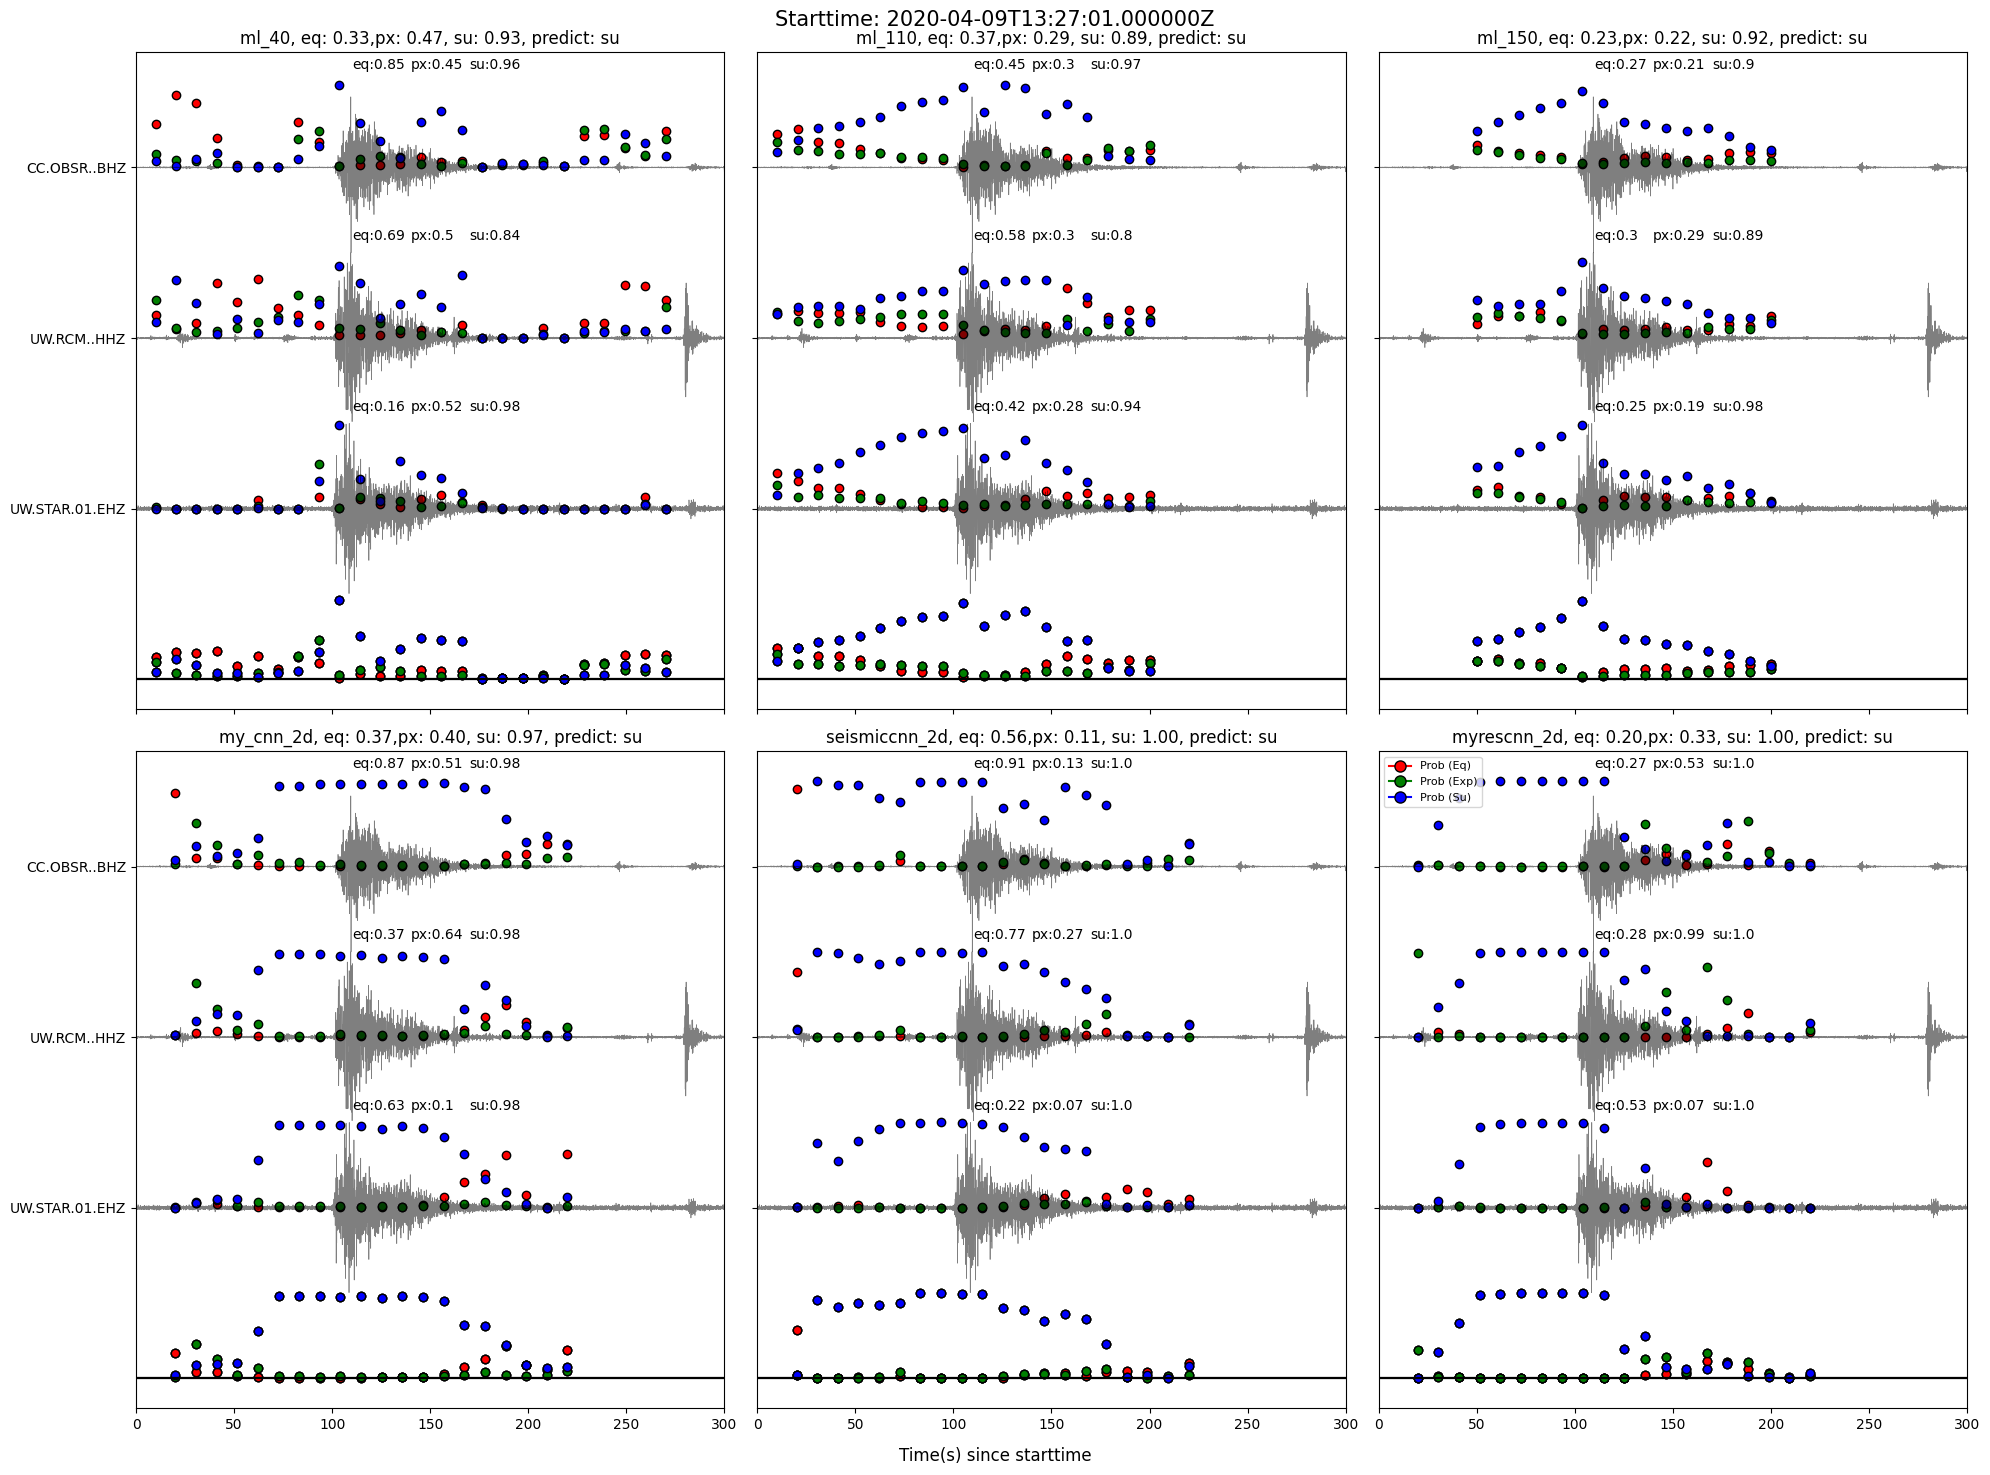

In [11]:
from all_models_classification import plot_waveform_and_probs

model_probs_dict = {'ml_40':stn_probs_ml_40, 
                  'ml_110':stn_probs_ml_110,
                  'ml_150':stn_probs_ml_150,
                  'mycnn_2d':stn_probs_mycnn_2d,
                  'seismiccnn_2d':stn_probs_seismiccnn_2d,
                  'myrescnn_2d':stn_probs_myrescnn_2d}

plot_waveform_and_probs(big_reshaped_data, 
                            model_probs_dict, 
                            start_time, end_time, orig_sr,   
                            big_station_ids, figsize=(20, 15), threshold = 0.1)

## Second We will try our surface event detector to detect a Icefall and Ice Avalanche that occurred on  Nisqually Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/14743775 and we can also see a video of the event here - https://www.youtube.com/watch?v=iDle-31t238


- Event type: Rockfall, Rock and Ice Avalanche
- Start Date: 	2011-06-25 23:04:05
- End Date: 2011-06-25 23:11:15
- Location: Nisqually Glacier


In [12]:
before = 100
start_time = obspy.UTCDateTime(2011, 6, 25, 23, 4, 5) - before
end_time = start_time + 300
        
stations_id = ['UW.RCS', 'UW.RCM', 'CC.PARA', 'CC.COPP', 'CC.PANH', 'CC.OBSR']
location = "*"

In [13]:
client = Client("IRIS")

# Define parameters
orig_sr = 100  # original sampling rate
new_sr = 50    # new sampling rate
stride = 10 * orig_sr
lowpass = 1
highpass = 20
window_length = 100
channel_patterns = ["EH", "BH", "HH"]



# Initialize result lists


# Function to process and compute probabilities
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )






# Compute probabilities for different models
stn_probs_mycnn_1d, _, big_station_ids = process_model(
    model_mycnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_mycnn_2d, big_reshaped_data, _ = process_model(
    model_mycnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_myrescnn_2d, _, _ = process_model(
    model_myrescnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)




# The model parameter is irrelevant for ml models. 
model = model_mycnn_1d
# Machine Learning model probabilities
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)


 50%|█████     | 3/6 [00:00<00:00, 21.42it/s]

No valid data available for station RCS. Skipping.
No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
Detailed response of server:


No valid data available for station COPP. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station OBSR has all 3 components for BH channels.


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)


 33%|███▎      | 2/6 [00:00<00:00, 18.24it/s]

No valid data available for station RCS. Skipping.
No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
Detailed response of server:


No valid data available for station COPP. Skipping.
Station PANH has all 3 components for BH channels.


 83%|████████▎ | 5/6 [00:00<00:00,  5.59it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station OBSR has all 3 components for BH channels.


  0%|          | 0/6 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.


 50%|█████     | 3/6 [00:00<00:00, 21.95it/s]

No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
Detailed response of server:


No valid data available for station COPP. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station OBSR has all 3 components for BH channels.


 17%|█▋        | 1/6 [00:00<00:00,  9.98it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.


 50%|█████     | 3/6 [00:00<00:00, 11.03it/s]

No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
Detailed response of server:


No valid data available for station COPP. Skipping.
Station PANH has all 3 components for BH channels.


 83%|████████▎ | 5/6 [00:01<00:00,  4.22it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station OBSR has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)


 50%|█████     | 3/6 [00:00<00:00, 22.14it/s]

No valid data available for station RCS. Skipping.
No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
Detailed response of server:


No valid data available for station COPP. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)
Station OBSR has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 33%|███▎      | 2/6 [00:00<00:00, 18.60it/s]

No valid data available for station RCS. Skipping.
No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
Detailed response of server:


No valid data available for station COPP. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 83%|████████▎ | 5/6 [00:02<00:00,  2.11it/s]

Station OBSR has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 50%|█████     | 3/6 [00:00<00:00, 20.65it/s]

No valid data available for station RCS. Skipping.
No valid data available for station RCM. Skipping.
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for COPP: No data available for request.
Detailed response of server:


No valid data available for station COPP. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)
Station OBSR has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


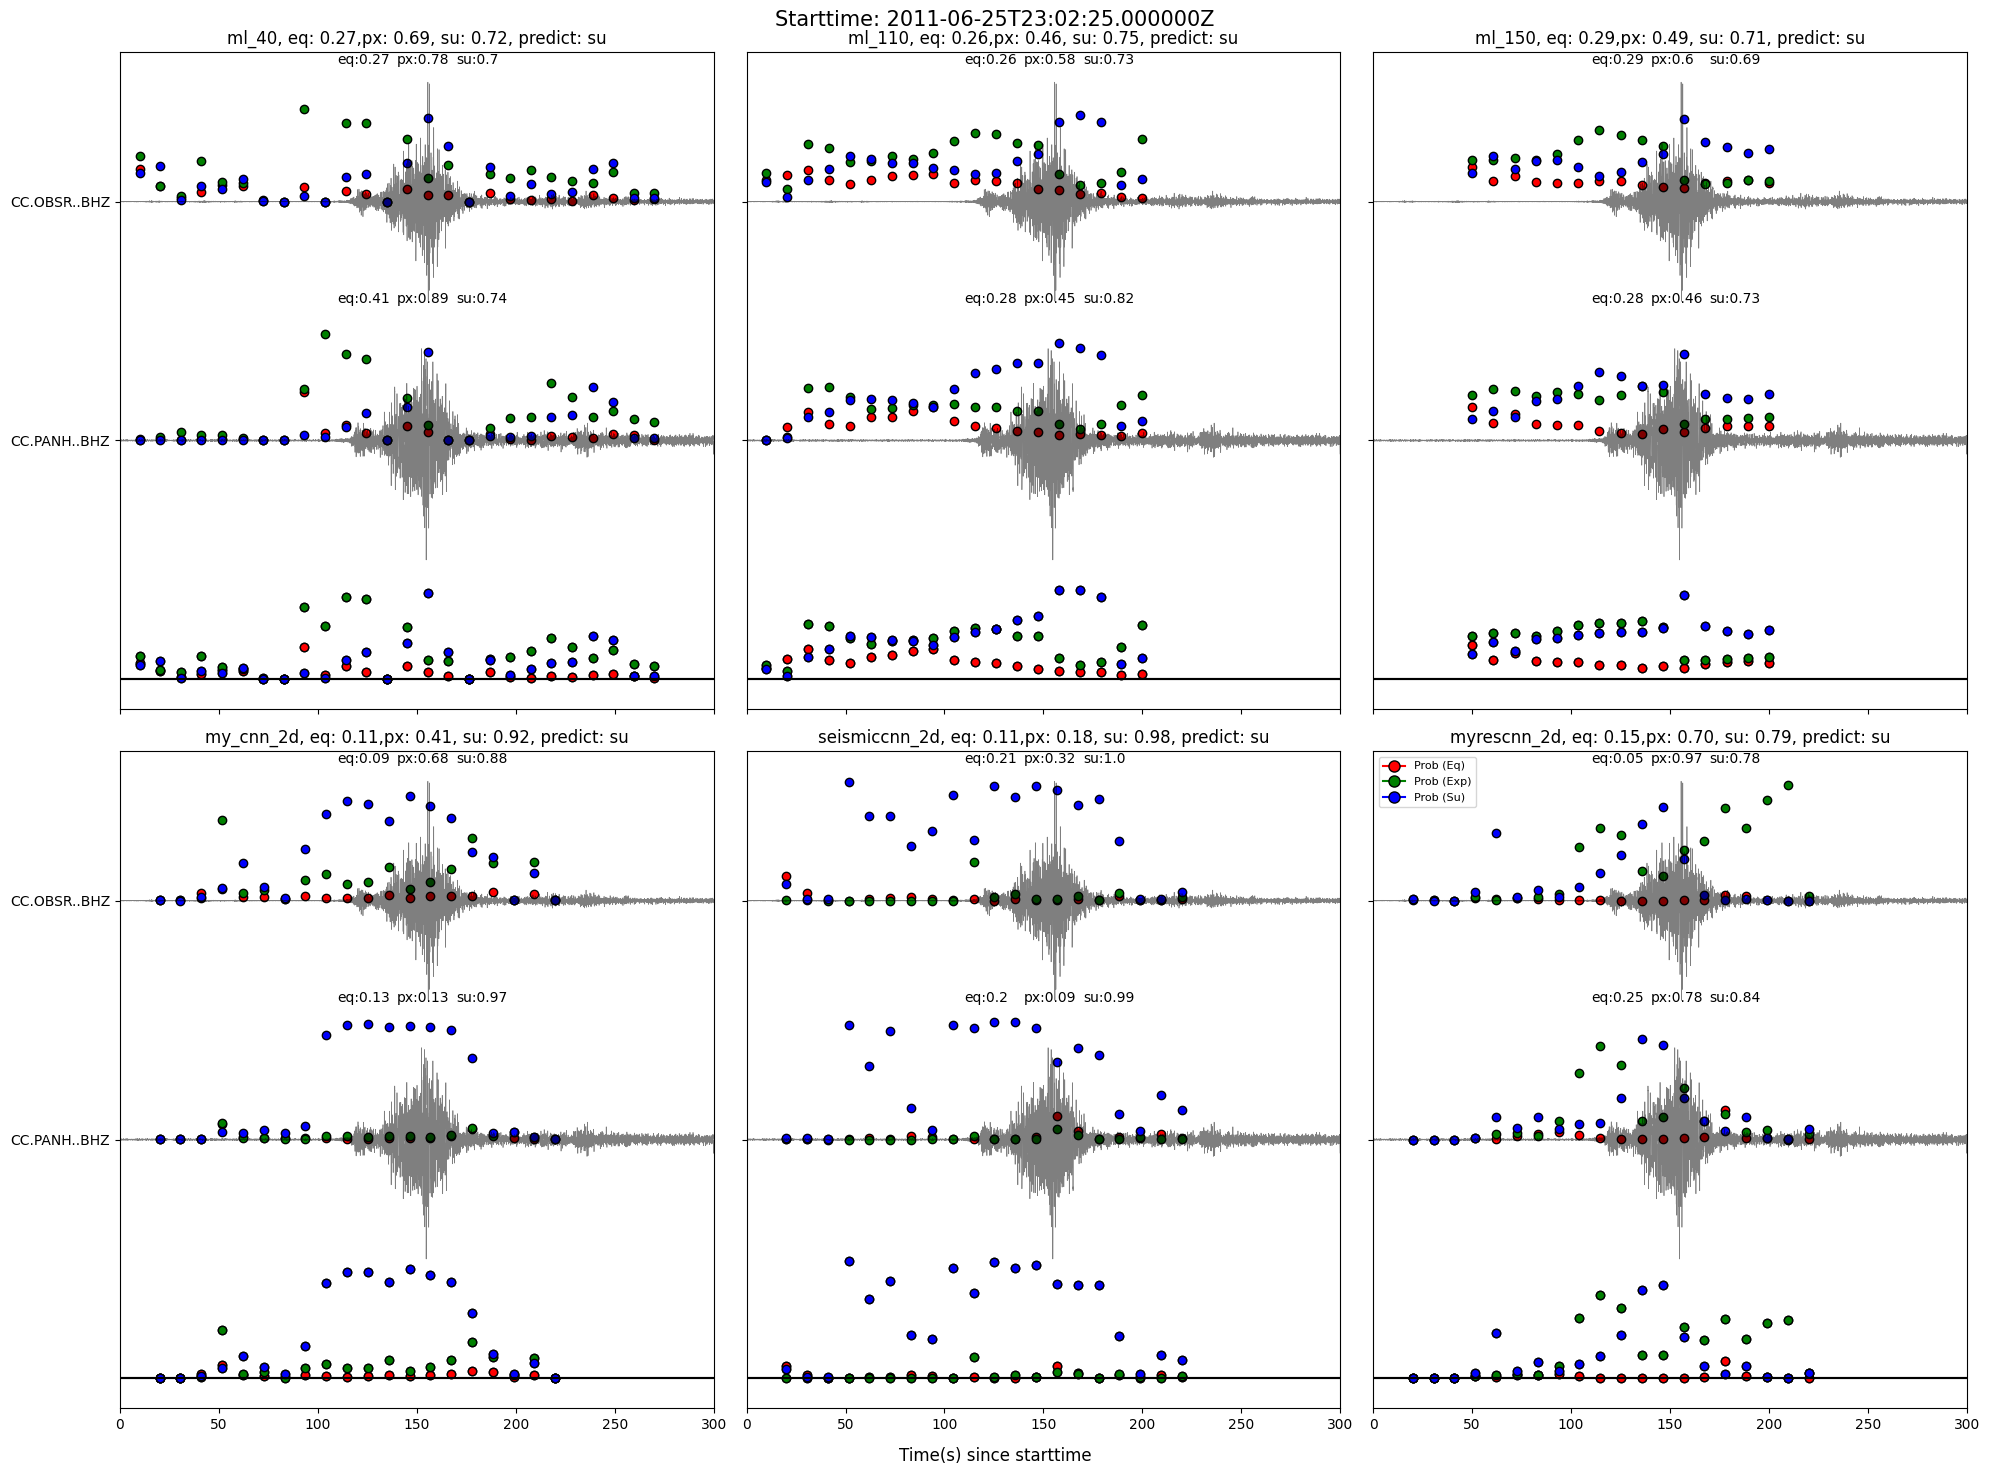

In [14]:
from all_models_classification import plot_waveform_and_probs

model_probs_dict = {'ml_40':stn_probs_ml_40, 
                  'ml_110':stn_probs_ml_110,
                  'ml_150':stn_probs_ml_150,
                  'mycnn_2d':stn_probs_mycnn_2d,
                  'seismiccnn_2d':stn_probs_seismiccnn_2d,
                  'myrescnn_2d':stn_probs_myrescnn_2d}

plot_waveform_and_probs(big_reshaped_data, 
                            model_probs_dict, 
                            start_time, end_time, orig_sr,   
                            big_station_ids, figsize=(20, 15), threshold = 0.1)

## Third We will try our surface event detector to detect a Debris Flow that occurred on  Nisqually Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/20008839 and we can also see more info of the event here - 


- Event type: Debris Flow
- Start Date: 	2019-09-27 00:43:20
- End Date: 	2019-09-27 01:29:22
- Location: Mount Rainier


In [15]:
before = 100
start_time = obspy.UTCDateTime(2019, 9, 27, 0, 43, 20) - before
end_time = start_time + 300
        
stations_id = [ 'UW.LON', 'UW.RER','UW.LO2', 'UW.RCS', 'UW.RCM', 'UW.STAR', 'CC.PARA', 'CC.MIRR', 'CC.TABR']
location = "*"

In [16]:
client = Client("IRIS")

# Define parameters
orig_sr = 100  # original sampling rate
new_sr = 50    # new sampling rate
stride = 10 * orig_sr
lowpass = 1
highpass = 20
window_length = 100
channel_patterns = ["EH", "BH", "HH"]



# Initialize result lists


# Function to process and compute probabilities
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )






# Compute probabilities for different models
stn_probs_mycnn_1d, _, big_station_ids = process_model(
    model_mycnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_mycnn_2d, big_reshaped_data, _ = process_model(
    model_mycnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_myrescnn_2d, _, _ = process_model(
    model_myrescnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)




# The model parameter is irrelevant for ml models. 
model = model_mycnn_1d
# Machine Learning model probabilities
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)


  0%|          | 0/9 [00:00<?, ?it/s]

Station LON has all 3 components for HH channels.


 11%|█         | 1/9 [00:01<00:08,  1.08s/it]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RER. Skipping.


 33%|███▎      | 3/9 [00:01<00:01,  3.09it/s]

No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)


 56%|█████▌    | 5/9 [00:02<00:01,  2.09it/s]

Station STAR has all 3 components for EH channels.


 67%|██████▋   | 6/9 [00:03<00:01,  1.53it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for MIRR: No data available for request.
Detailed response of server:


No valid data available for station MIRR. Skipping.


  0%|          | 0/9 [00:00<?, ?it/s]

Error fetching station data for TABR: No data available for request.
Detailed response of server:


No valid data available for station TABR. Skipping.
Station LON has all 3 components for HH channels.


 33%|███▎      | 3/9 [00:00<00:01,  4.64it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RER. Skipping.
No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.


 56%|█████▌    | 5/9 [00:01<00:01,  3.40it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.


  0%|          | 0/9 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for MIRR: No data available for request.
Detailed response of server:


No valid data available for station MIRR. Skipping.
Error fetching station data for TABR: No data available for request.
Detailed response of server:


No valid data available for station TABR. Skipping.
Station LON has all 3 components for HH channels.


 11%|█         | 1/9 [00:00<00:05,  1.46it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RER. Skipping.


 33%|███▎      | 3/9 [00:00<00:01,  4.36it/s]

No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.


 56%|█████▌    | 5/9 [00:01<00:01,  3.36it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.


 67%|██████▋   | 6/9 [00:02<00:01,  2.50it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for MIRR: No data available for request.
Detailed response of server:


No valid data available for station MIRR. Skipping.


  0%|          | 0/9 [00:00<?, ?it/s]

Error fetching station data for TABR: No data available for request.
Detailed response of server:


No valid data available for station TABR. Skipping.
Station LON has all 3 components for HH channels.


 33%|███▎      | 3/9 [00:00<00:01,  4.94it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RER. Skipping.
No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.


 56%|█████▌    | 5/9 [00:01<00:01,  3.10it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.


 89%|████████▉ | 8/9 [00:02<00:00,  3.90it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for MIRR: No data available for request.
Detailed response of server:


No valid data available for station MIRR. Skipping.


  0%|          | 0/9 [00:00<?, ?it/s]

Error fetching station data for TABR: No data available for request.
Detailed response of server:


No valid data available for station TABR. Skipping.
Station LON has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 33%|███▎      | 3/9 [00:02<00:03,  1.66it/s]

No valid data available for station RER. Skipping.
No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 56%|█████▌    | 5/9 [00:04<00:03,  1.12it/s]

Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/9 [00:00<?, ?it/s]

Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for MIRR: No data available for request.
Detailed response of server:


No valid data available for station MIRR. Skipping.
Error fetching station data for TABR: No data available for request.
Detailed response of server:


No valid data available for station TABR. Skipping.
Station LON has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 33%|███▎      | 3/9 [00:02<00:03,  1.78it/s]

No valid data available for station RER. Skipping.
No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 56%|█████▌    | 5/9 [00:04<00:03,  1.25it/s]

Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/9 [00:00<?, ?it/s]

Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for MIRR: No data available for request.
Detailed response of server:


No valid data available for station MIRR. Skipping.
Error fetching station data for TABR: No data available for request.
Detailed response of server:


No valid data available for station TABR. Skipping.
Station LON has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 33%|███▎      | 3/9 [00:01<00:02,  2.03it/s]

No valid data available for station RER. Skipping.
No valid data available for station LO2. Skipping.
No valid data available for station RCS. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 56%|█████▌    | 5/9 [00:03<00:02,  1.37it/s]

Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]

Error fetching station data for PARA: No data available for request.
Detailed response of server:


No valid data available for station PARA. Skipping.
Error fetching station data for MIRR: No data available for request.
Detailed response of server:


No valid data available for station MIRR. Skipping.
Error fetching station data for TABR: No data available for request.
Detailed response of server:


No valid data available for station TABR. Skipping.


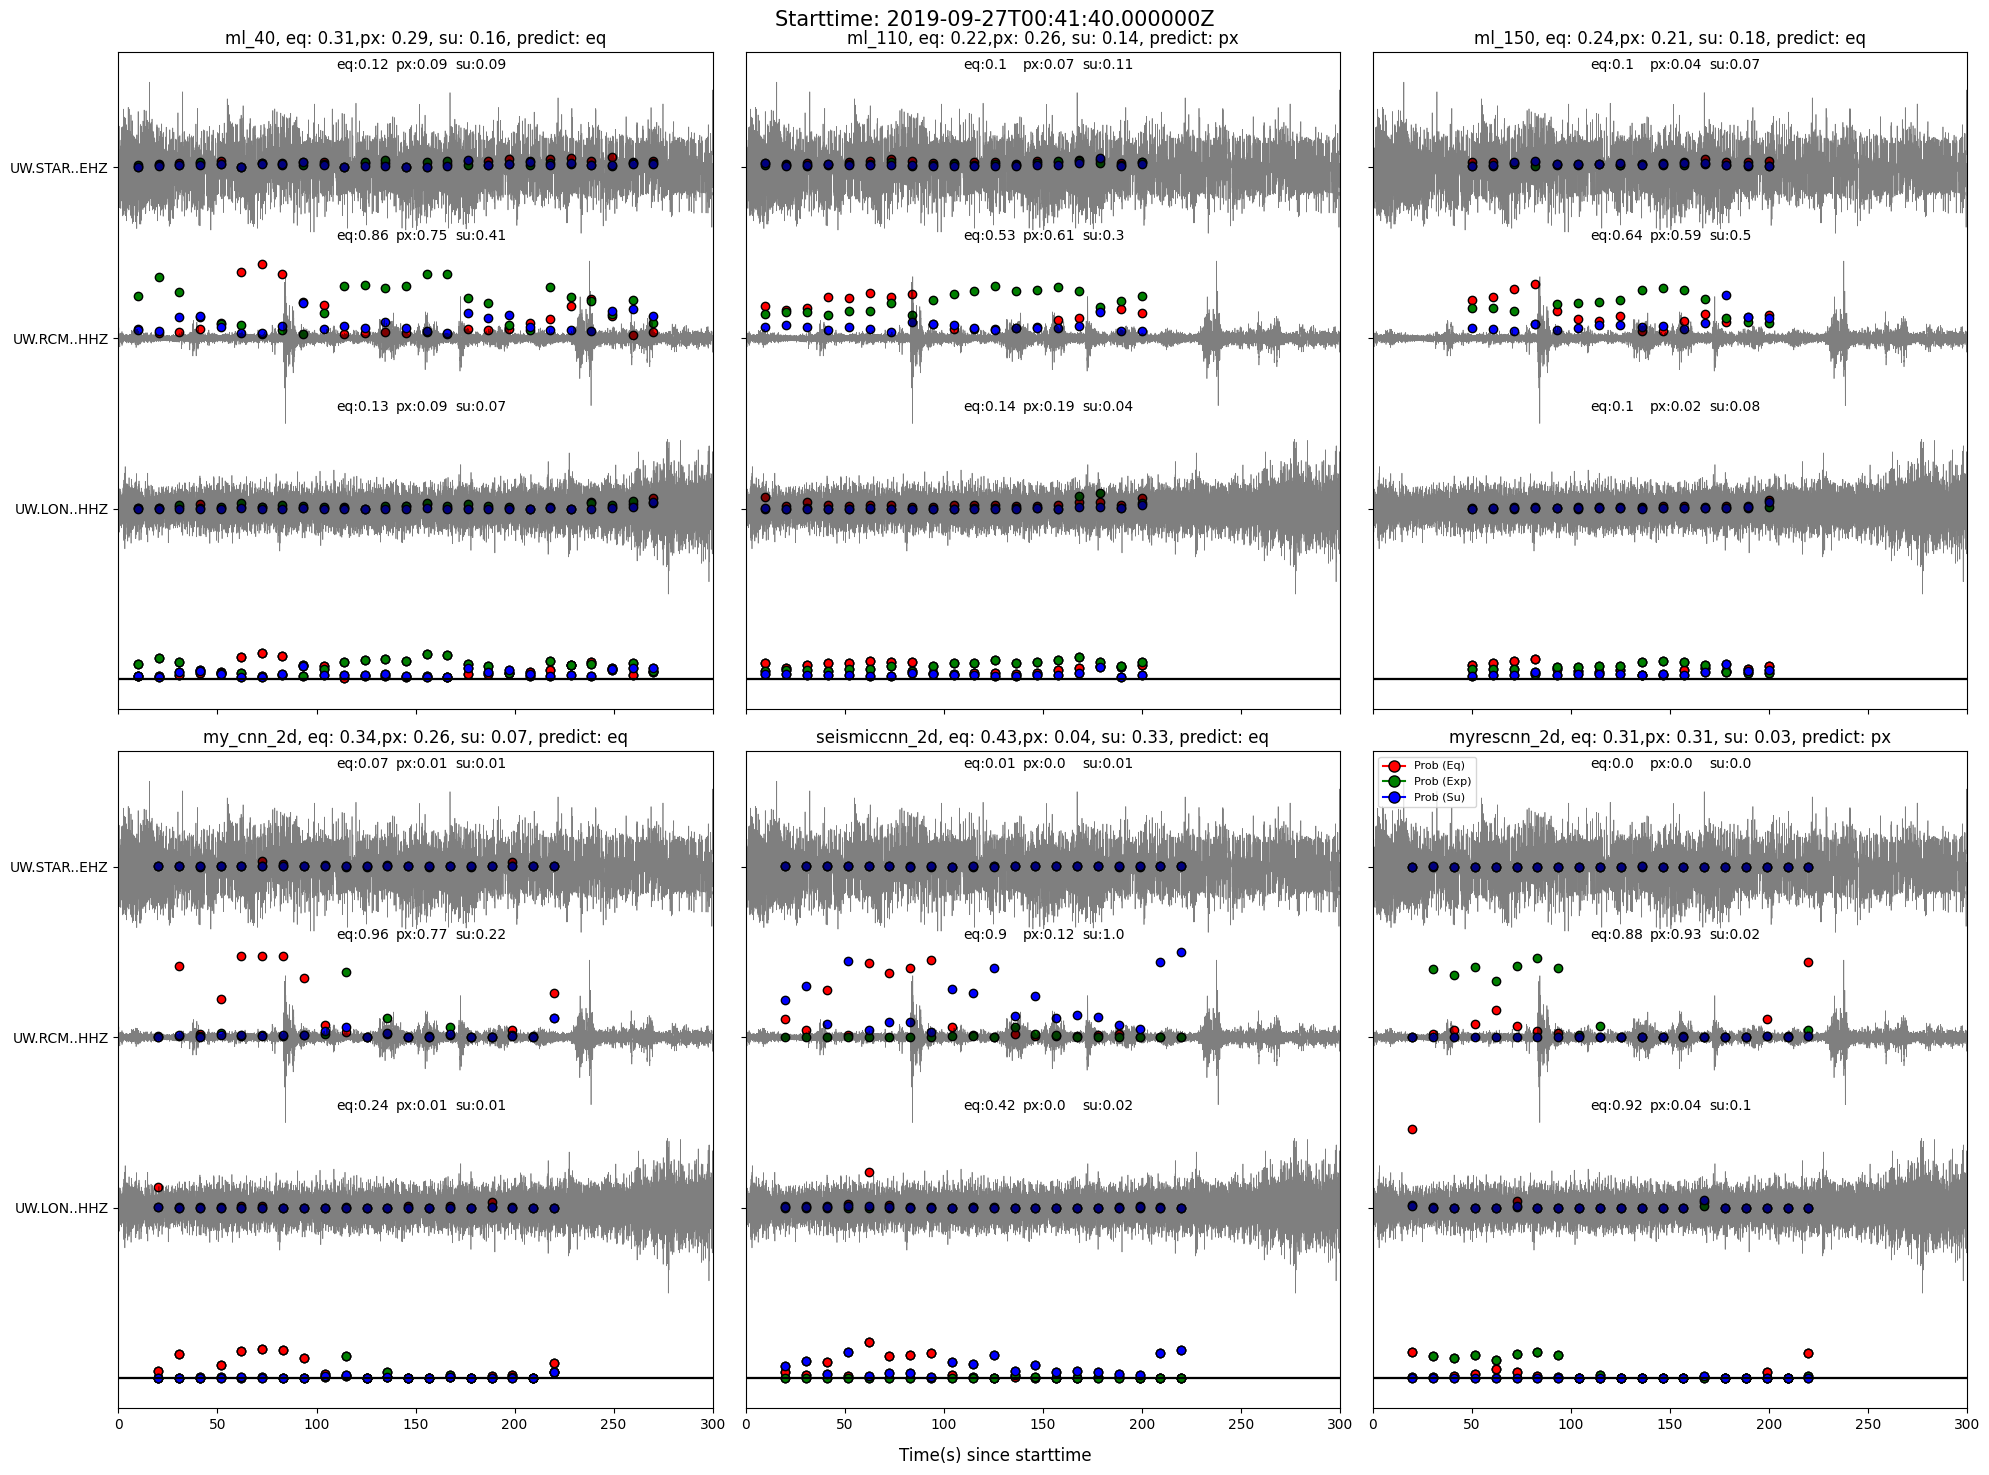

In [17]:
from all_models_classification import plot_waveform_and_probs

model_probs_dict = {'ml_40':stn_probs_ml_40, 
                  'ml_110':stn_probs_ml_110,
                  'ml_150':stn_probs_ml_150,
                  'mycnn_2d':stn_probs_mycnn_2d,
                  'seismiccnn_2d':stn_probs_seismiccnn_2d,
                  'myrescnn_2d':stn_probs_myrescnn_2d}

plot_waveform_and_probs(big_reshaped_data, 
                            model_probs_dict, 
                            start_time, end_time, orig_sr,   
                            big_station_ids, figsize=(20, 15), threshold = 0.1)

## Another confirmed rockfall, this rockfall fooled the PNSN automated event detection and was labeled as Earthquake initially but further analysis revealed its actually a rockfall

More information about this event can be seen here - 
https://pnsn.org/blog/2015/08/21/summer-rockfall-time-yet-again

In [18]:
before = 100
start_time = obspy.UTCDateTime(2019, 9, 27, 0, 43, 20) - before
end_time = start_time + 300
        
stations_id = [ 'UW.RER', 'UW.RCM', 'UW.STAR', 'UW.RCS', 'UW.FMW', 'UW.WPW', 'CC.PANH']
location = "*"

In [19]:
client = Client("IRIS")

# Define parameters
orig_sr = 100  # original sampling rate
new_sr = 50    # new sampling rate
stride = 10 * orig_sr
lowpass = 1
highpass = 20
window_length = 100
channel_patterns = ["EH", "BH", "HH"]



# Initialize result lists


# Function to process and compute probabilities
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )






# Compute probabilities for different models
stn_probs_mycnn_1d, _, big_station_ids = process_model(
    model_mycnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_mycnn_2d, big_reshaped_data, _ = process_model(
    model_mycnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_myrescnn_2d, _, _ = process_model(
    model_myrescnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)




# The model parameter is irrelevant for ml models. 
model = model_mycnn_1d
# Machine Learning model probabilities
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)


  0%|          | 0/7 [00:00<?, ?it/s]

No valid data available for station RER. Skipping.
Station RCM has all 3 components for HH channels.


 29%|██▊       | 2/7 [00:00<00:01,  2.84it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.


 43%|████▎     | 3/7 [00:01<00:01,  2.07it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.
Station FMW has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)


 71%|███████▏  | 5/7 [00:02<00:01,  1.89it/s]

Error fetching station data for WPW: No data available for request.
Detailed response of server:


No valid data available for station WPW. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)


  0%|          | 0/7 [00:00<?, ?it/s]

No valid data available for station RER. Skipping.
Station RCM has all 3 components for HH channels.


 29%|██▊       | 2/7 [00:00<00:01,  2.90it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.


 43%|████▎     | 3/7 [00:01<00:01,  2.13it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.
Station FMW has all 3 components for HH channels.


 71%|███████▏  | 5/7 [00:01<00:00,  2.56it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Error fetching station data for WPW: No data available for request.
Detailed response of server:


No valid data available for station WPW. Skipping.
Station PANH has all 3 components for BH channels.


  0%|          | 0/7 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RER. Skipping.
Station RCM has all 3 components for HH channels.


 29%|██▊       | 2/7 [00:00<00:01,  2.92it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.


 43%|████▎     | 3/7 [00:01<00:01,  2.13it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.
Station FMW has all 3 components for HH channels.


 71%|███████▏  | 5/7 [00:02<00:00,  2.47it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Error fetching station data for WPW: No data available for request.
Detailed response of server:


No valid data available for station WPW. Skipping.
Station PANH has all 3 components for BH channels.


  0%|          | 0/7 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RER. Skipping.
Station RCM has all 3 components for HH channels.


 29%|██▊       | 2/7 [00:00<00:01,  2.56it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station STAR has all 3 components for EH channels.


 43%|████▎     | 3/7 [00:01<00:02,  1.96it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RCS. Skipping.
Station FMW has all 3 components for HH channels.


 71%|███████▏  | 5/7 [00:02<00:00,  2.40it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Error fetching station data for WPW: No data available for request.
Detailed response of server:


No valid data available for station WPW. Skipping.
Station PANH has all 3 components for BH channels.


  0%|          | 0/7 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station RER. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 29%|██▊       | 2/7 [00:02<00:06,  1.28s/it]

Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


 43%|████▎     | 3/7 [00:04<00:06,  1.63s/it]

No valid data available for station RCS. Skipping.
Station FMW has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 71%|███████▏  | 5/7 [00:06<00:02,  1.37s/it]

Error fetching station data for WPW: No data available for request.
Detailed response of server:


No valid data available for station WPW. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/7 [00:00<?, ?it/s]

No valid data available for station RER. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 29%|██▊       | 2/7 [00:02<00:05,  1.01s/it]

Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


 43%|████▎     | 3/7 [00:04<00:05,  1.43s/it]

No valid data available for station RCS. Skipping.
Station FMW has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 71%|███████▏  | 5/7 [00:06<00:02,  1.28s/it]

Error fetching station data for WPW: No data available for request.
Detailed response of server:


No valid data available for station WPW. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/7 [00:00<?, ?it/s]

No valid data available for station RER. Skipping.
Station RCM has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 29%|██▊       | 2/7 [00:01<00:04,  1.09it/s]

Station STAR has all 3 components for EH channels.
Reshaped data: (1, 3, 30000)


 43%|████▎     | 3/7 [00:03<00:05,  1.29s/it]

No valid data available for station RCS. Skipping.
Station FMW has all 3 components for HH channels.
Reshaped data: (1, 3, 30000)


 71%|███████▏  | 5/7 [00:05<00:02,  1.08s/it]

Error fetching station data for WPW: No data available for request.
Detailed response of server:


No valid data available for station WPW. Skipping.
Station PANH has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


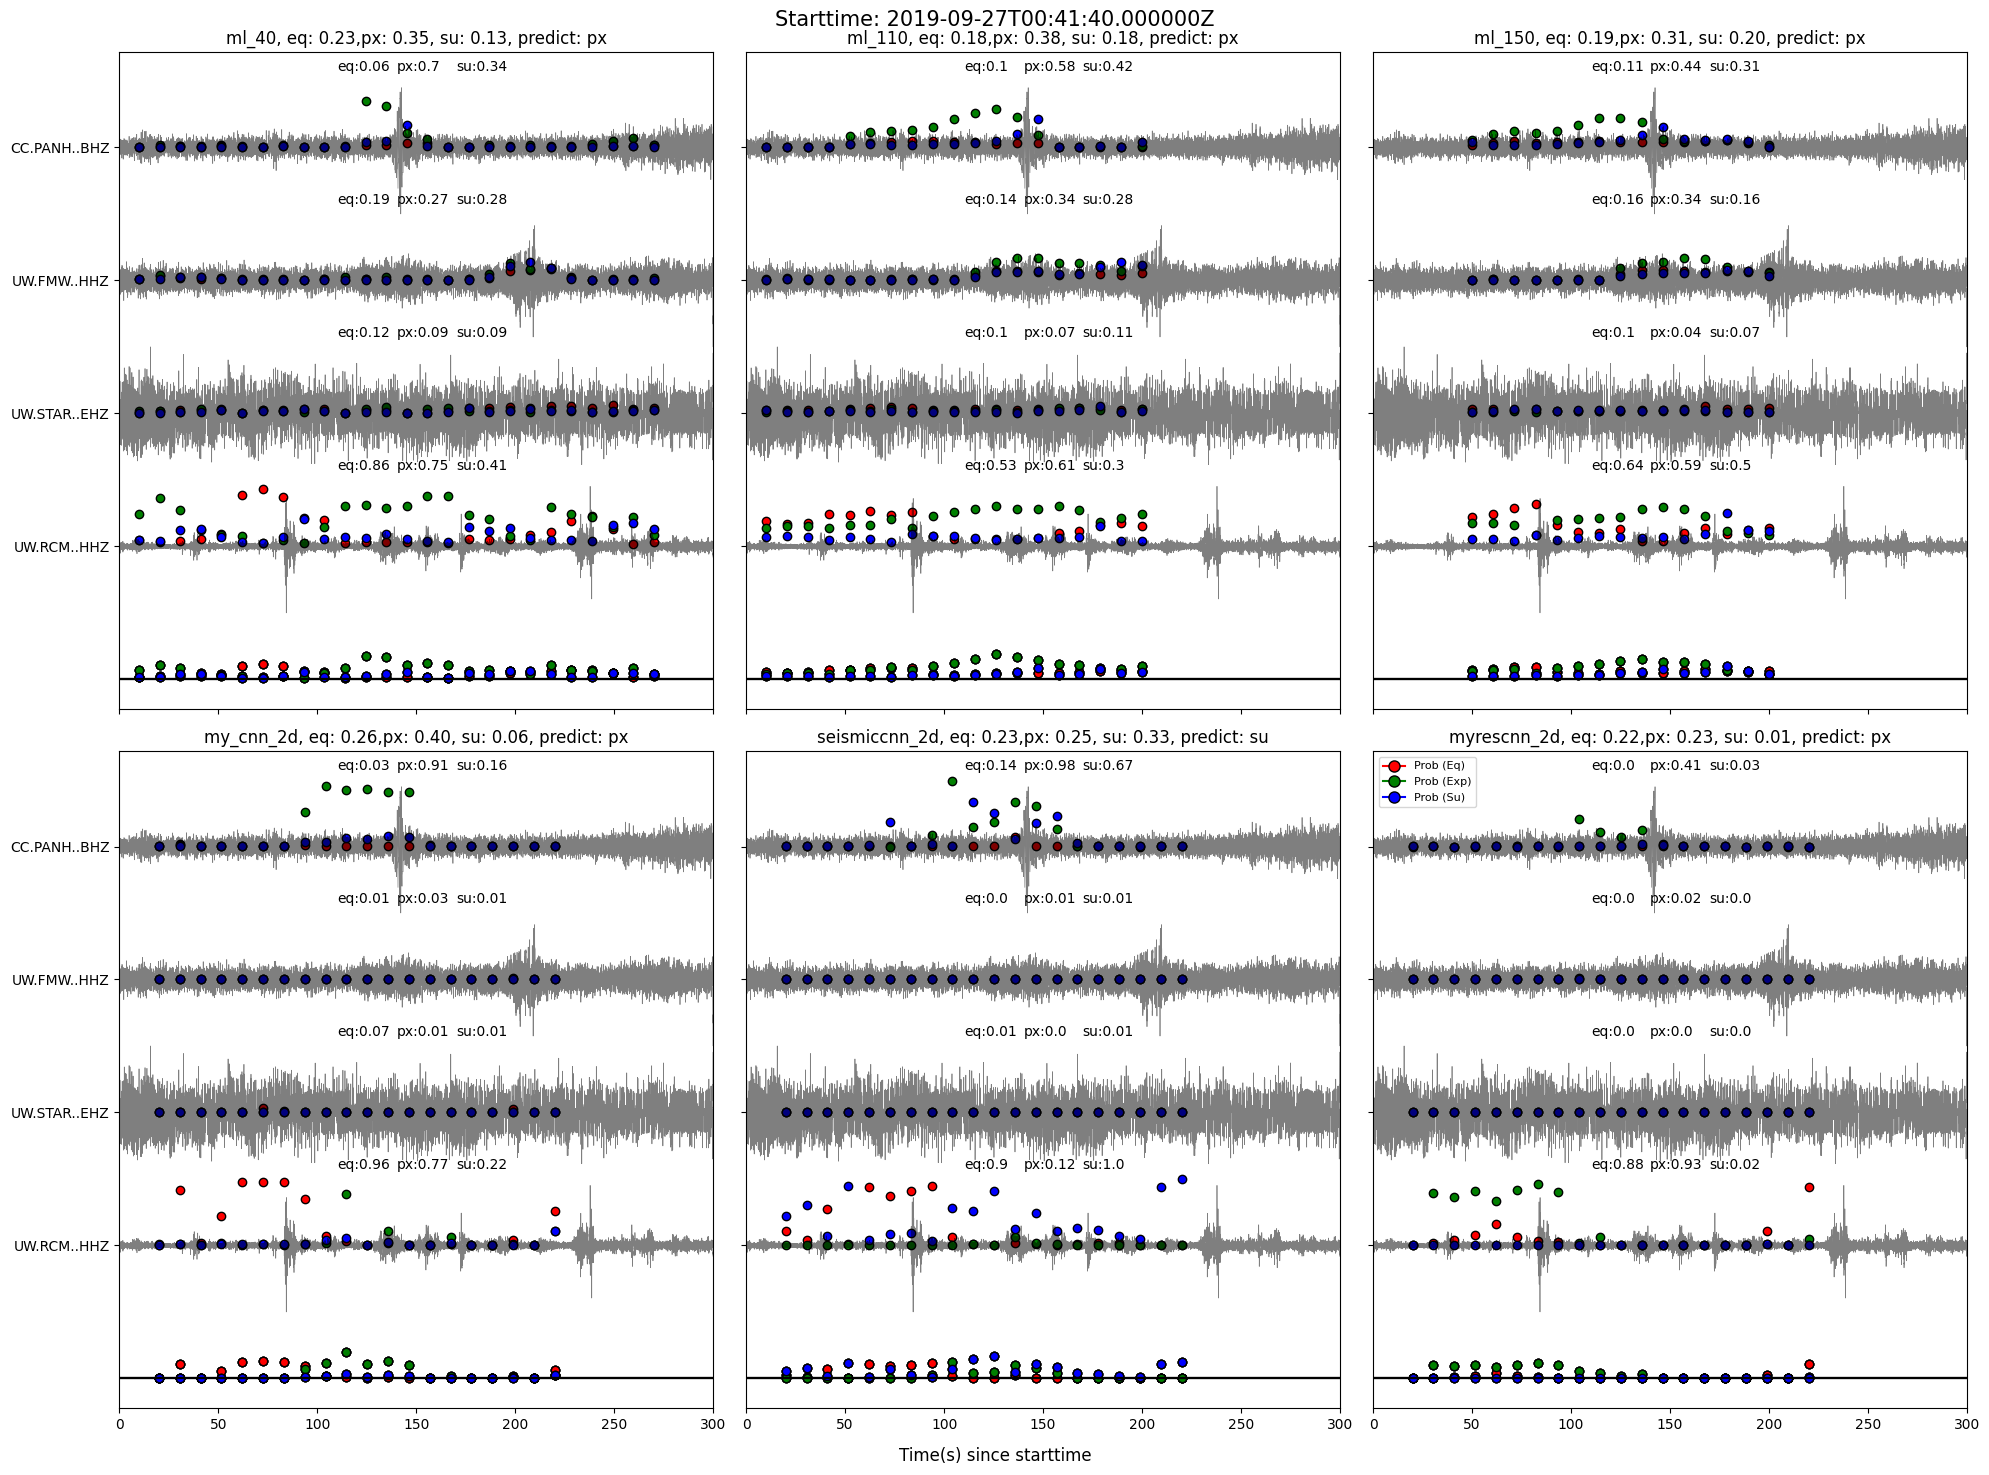

In [20]:
from all_models_classification import plot_waveform_and_probs

model_probs_dict = {'ml_40':stn_probs_ml_40, 
                  'ml_110':stn_probs_ml_110,
                  'ml_150':stn_probs_ml_150,
                  'mycnn_2d':stn_probs_mycnn_2d,
                  'seismiccnn_2d':stn_probs_seismiccnn_2d,
                  'myrescnn_2d':stn_probs_myrescnn_2d}

plot_waveform_and_probs(big_reshaped_data, 
                            model_probs_dict, 
                            start_time, end_time, orig_sr,   
                            big_station_ids, figsize=(20, 15), threshold = 0.1)

## Testing the model on the events in different region than the model was trained on

- Here we are going to test our model on two large avalanches described very well in this paper - https://esurf.copernicus.org/articles/9/271/2021/ 

These avalanches occur on Iliamna volcano, one in 2016 and other one in 2019

In [28]:
before = 10
start_time = obspy.UTCDateTime(2016, 5, 22, 7, 56, 0) - before
end_time = start_time + 300
        
stations_id = ['AV.ILSW', 'TA.O20K', 'AV.OPT', 'AK.HOM']
location = "*"

In [29]:
client = Client("IRIS")

# Define parameters
orig_sr = 100  # original sampling rate
new_sr = 50    # new sampling rate
stride = 10 * orig_sr
lowpass = 1
highpass = 20
window_length = 100
channel_patterns = ["EH", "BH", "HH"]



# Initialize result lists


# Function to process and compute probabilities
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )






# Compute probabilities for different models
stn_probs_mycnn_1d, _, big_station_ids = process_model(
    model_mycnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_mycnn_2d, big_reshaped_data, _ = process_model(
    model_mycnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_myrescnn_2d, _, _ = process_model(
    model_myrescnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)




# The model parameter is irrelevant for ml models. 
model = model_mycnn_1d
# Machine Learning model probabilities
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)

  0%|          | 0/4 [00:00<?, ?it/s]

Station ILSW has all 3 components for BH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.65it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station O20K has all 3 components for BH channels.


 50%|█████     | 2/4 [00:01<00:01,  1.62it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station ILSW has all 3 components for BH channels.


 25%|██▌       | 1/4 [00:00<00:02,  1.47it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station O20K has all 3 components for BH channels.


 50%|█████     | 2/4 [00:01<00:01,  1.45it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station ILSW has all 3 components for BH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.76it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station O20K has all 3 components for BH channels.


 50%|█████     | 2/4 [00:01<00:01,  1.62it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station ILSW has all 3 components for BH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.81it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station O20K has all 3 components for BH channels.


 50%|█████     | 2/4 [00:01<00:01,  1.66it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station ILSW has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:02<00:07,  2.43s/it]

Station O20K has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 50%|█████     | 2/4 [00:04<00:04,  2.40s/it]

No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/4 [00:00<?, ?it/s]

Station ILSW has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:01<00:05,  1.94s/it]

Station O20K has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 50%|█████     | 2/4 [00:03<00:03,  1.99s/it]

No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/4 [00:00<?, ?it/s]

Station ILSW has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:01<00:05,  1.82s/it]

Station O20K has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 75%|███████▌  | 3/4 [00:03<00:01,  1.10s/it]

No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


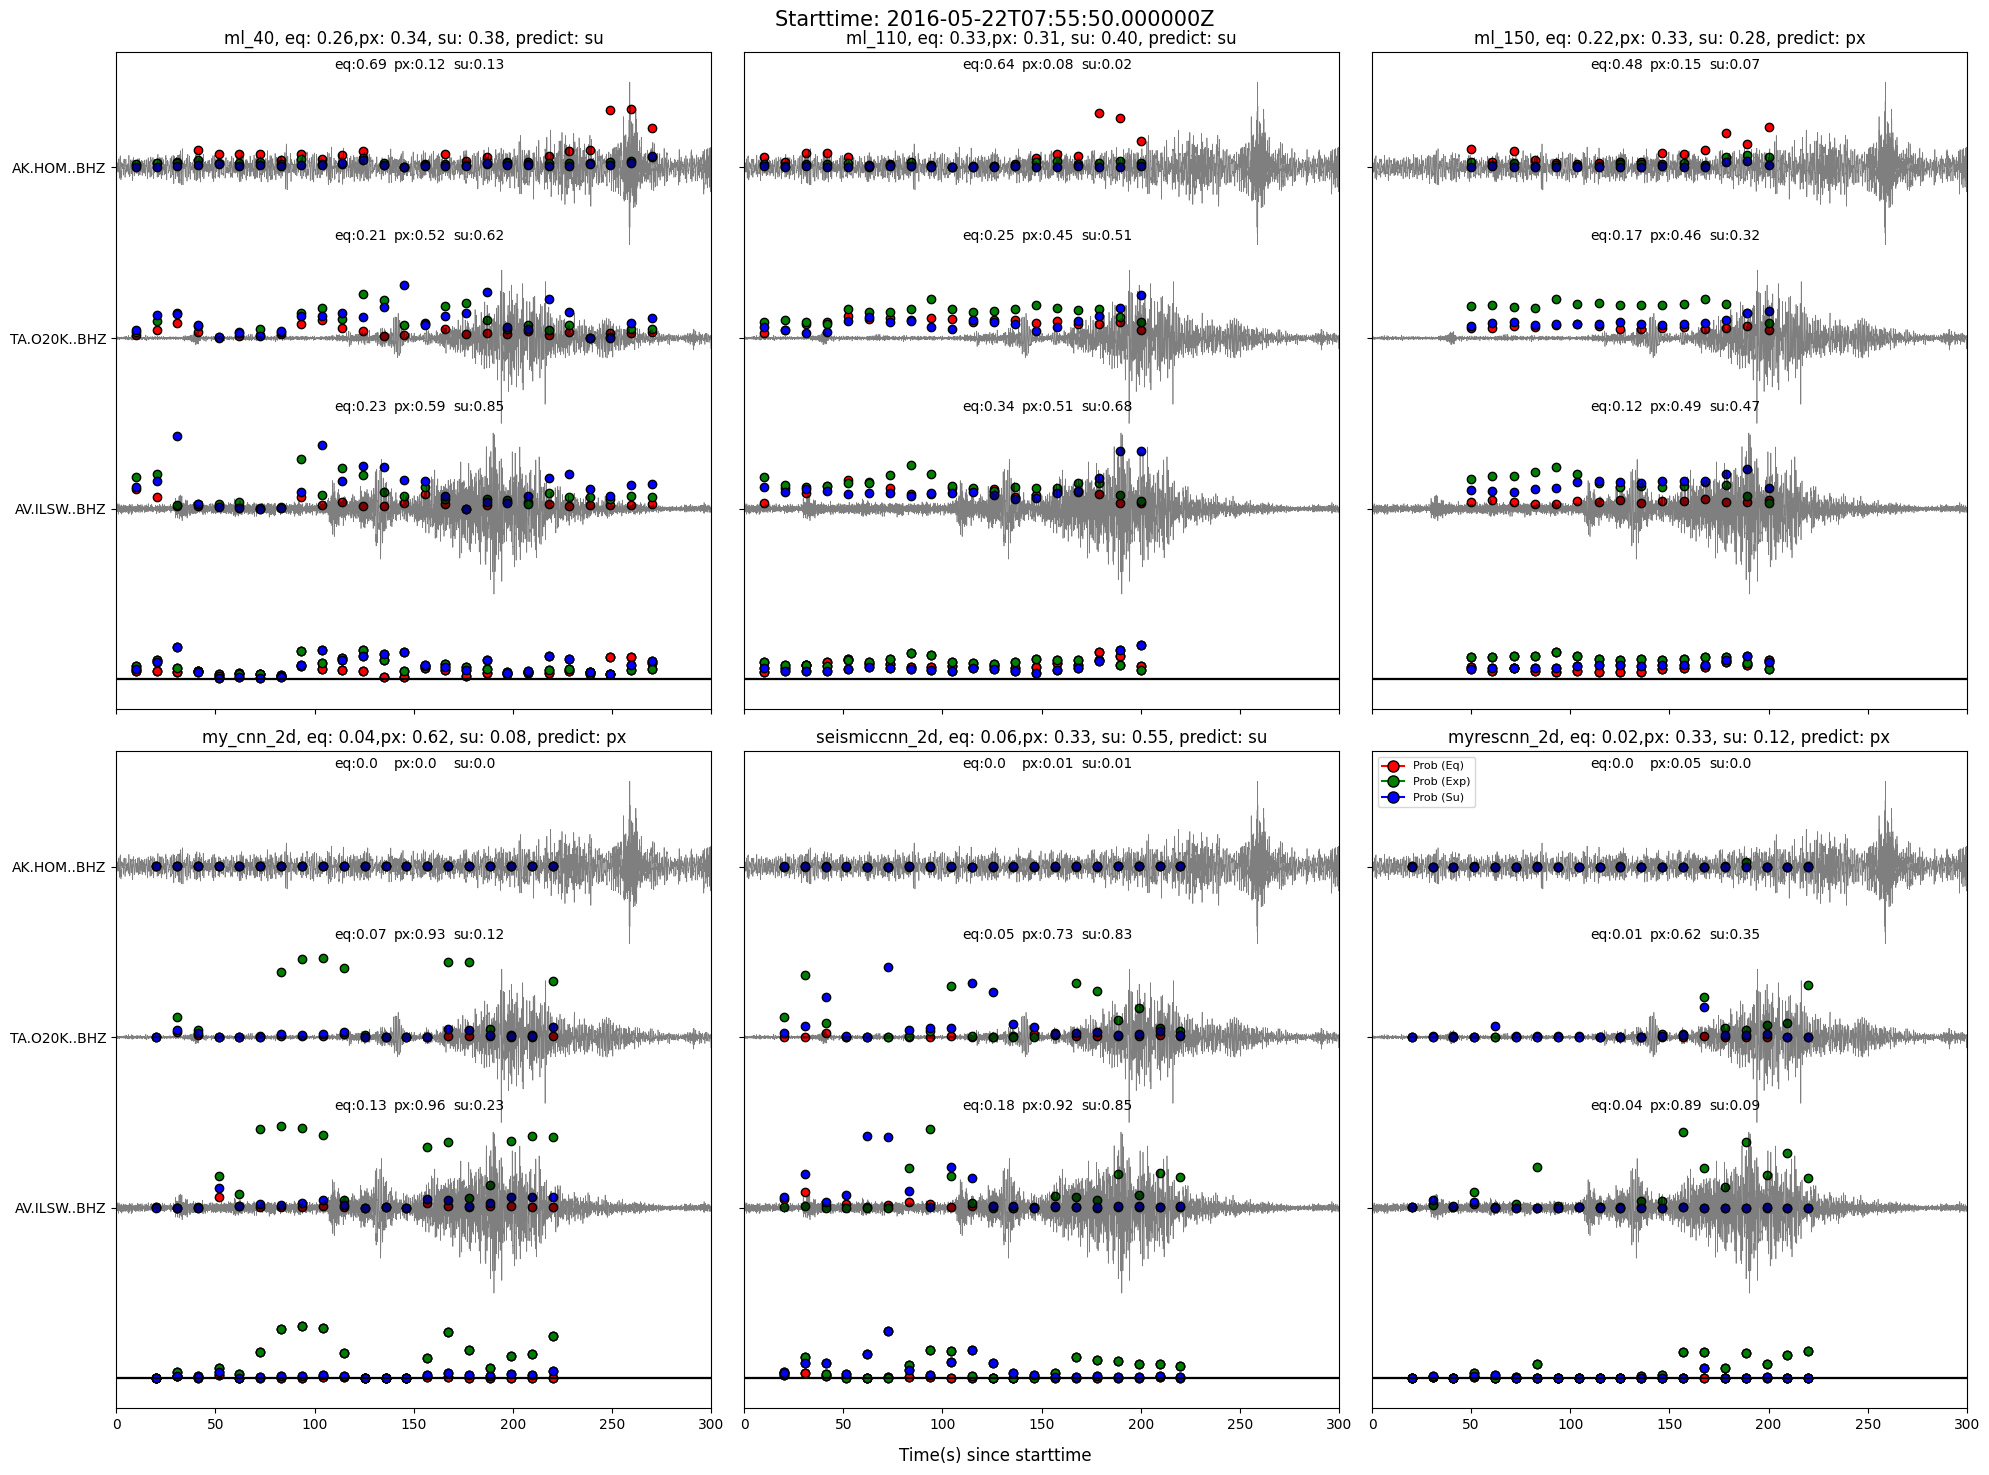

In [30]:
from all_models_classification import plot_waveform_and_probs

model_probs_dict = {'ml_40':stn_probs_ml_40, 
                  'ml_110':stn_probs_ml_110,
                  'ml_150':stn_probs_ml_150,
                  'mycnn_2d':stn_probs_mycnn_2d,
                  'seismiccnn_2d':stn_probs_seismiccnn_2d,
                  'myrescnn_2d':stn_probs_myrescnn_2d}

plot_waveform_and_probs(big_reshaped_data, 
                            model_probs_dict, 
                            start_time, end_time, orig_sr,   
                            big_station_ids, figsize=(20, 15), threshold = 0.1)

## Testing the model on 2019 event

In [35]:
before = 10
start_time = obspy.UTCDateTime(2019, 6, 21, 0, 0, 1) - before
end_time = start_time + 300
        
stations_id = ['AV.ILSW', 'TA.O20K', 'AV.OPT', 'AK.HOM']
location = "*"

In [36]:
client = Client("IRIS")

# Define parameters
orig_sr = 100  # original sampling rate
new_sr = 50    # new sampling rate
stride = 10 * orig_sr
lowpass = 1
highpass = 20
window_length = 100
channel_patterns = ["EH", "BH", "HH"]



# Initialize result lists


# Function to process and compute probabilities
def process_model(model, stations_id, location, start_time, end_time, one_d, model_type, filename):
    return compute_window_probs(
        stations_id=stations_id, location=location, start_time=start_time, 
        end_time=end_time, channel_patterns=channel_patterns, client=client, 
        stride=stride, orig_sr=orig_sr, new_sr=new_sr, window_length=window_length, 
        lowpass=lowpass, highpass=highpass, one_d=one_d, model=model, 
        model_type=model_type, filename=filename
    )






# Compute probabilities for different models
stn_probs_mycnn_1d, _, big_station_ids = process_model(
    model_mycnn_1d, stations_id, location, start_time, end_time, 
    one_d=True, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_mycnn_2d, big_reshaped_data, _ = process_model(
    model_mycnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_seismiccnn_2d, _, _ = process_model(
    model_seismiccnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)


stn_probs_myrescnn_2d, _, _ = process_model(
    model_myrescnn_2d, stations_id, location, start_time, end_time, 
    one_d=False, model_type='dl', filename='P_10_30_F_05_15_50'
)




# The model parameter is irrelevant for ml models. 
model = model_mycnn_1d
# Machine Learning model probabilities
stn_probs_ml_40, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_30_F_05_15_50'
)
stn_probs_ml_110, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_10_100_F_05_15_50'
)
stn_probs_ml_150, _, _ = process_model(
    model, stations_id, location, start_time, end_time, 
    one_d=False, model_type='ml', filename='P_50_100_F_05_15_50'
)

  0%|          | 0/4 [00:00<?, ?it/s]

Station ILSW has all 3 components for BH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.60it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station O20K has all 3 components for BH channels.


 50%|█████     | 2/4 [00:01<00:01,  1.45it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station ILSW has all 3 components for BH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.67it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station O20K has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)


 50%|█████     | 2/4 [00:01<00:01,  1.31it/s]

No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station ILSW has all 3 components for BH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.66it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station O20K has all 3 components for BH channels.


 50%|█████     | 2/4 [00:01<00:01,  1.60it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station ILSW has all 3 components for BH channels.


 25%|██▌       | 1/4 [00:00<00:01,  1.50it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station O20K has all 3 components for BH channels.


 50%|█████     | 2/4 [00:01<00:01,  1.43it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.


  0%|          | 0/4 [00:00<?, ?it/s]

Reshaped data: (1, 3, 30000)
(20, 3, 129, 38)
Station ILSW has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:02<00:07,  2.35s/it]

Station O20K has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 50%|█████     | 2/4 [00:04<00:04,  2.29s/it]

No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/4 [00:00<?, ?it/s]

Station ILSW has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:02<00:06,  2.02s/it]

Station O20K has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 50%|█████     | 2/4 [00:04<00:03,  2.00s/it]

No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


  0%|          | 0/4 [00:00<?, ?it/s]

Station ILSW has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 25%|██▌       | 1/4 [00:01<00:05,  1.79s/it]

Station O20K has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


 50%|█████     | 2/4 [00:03<00:03,  1.81s/it]

No valid data available for station OPT. Skipping.
Station HOM has all 3 components for BH channels.
Reshaped data: (1, 3, 30000)


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


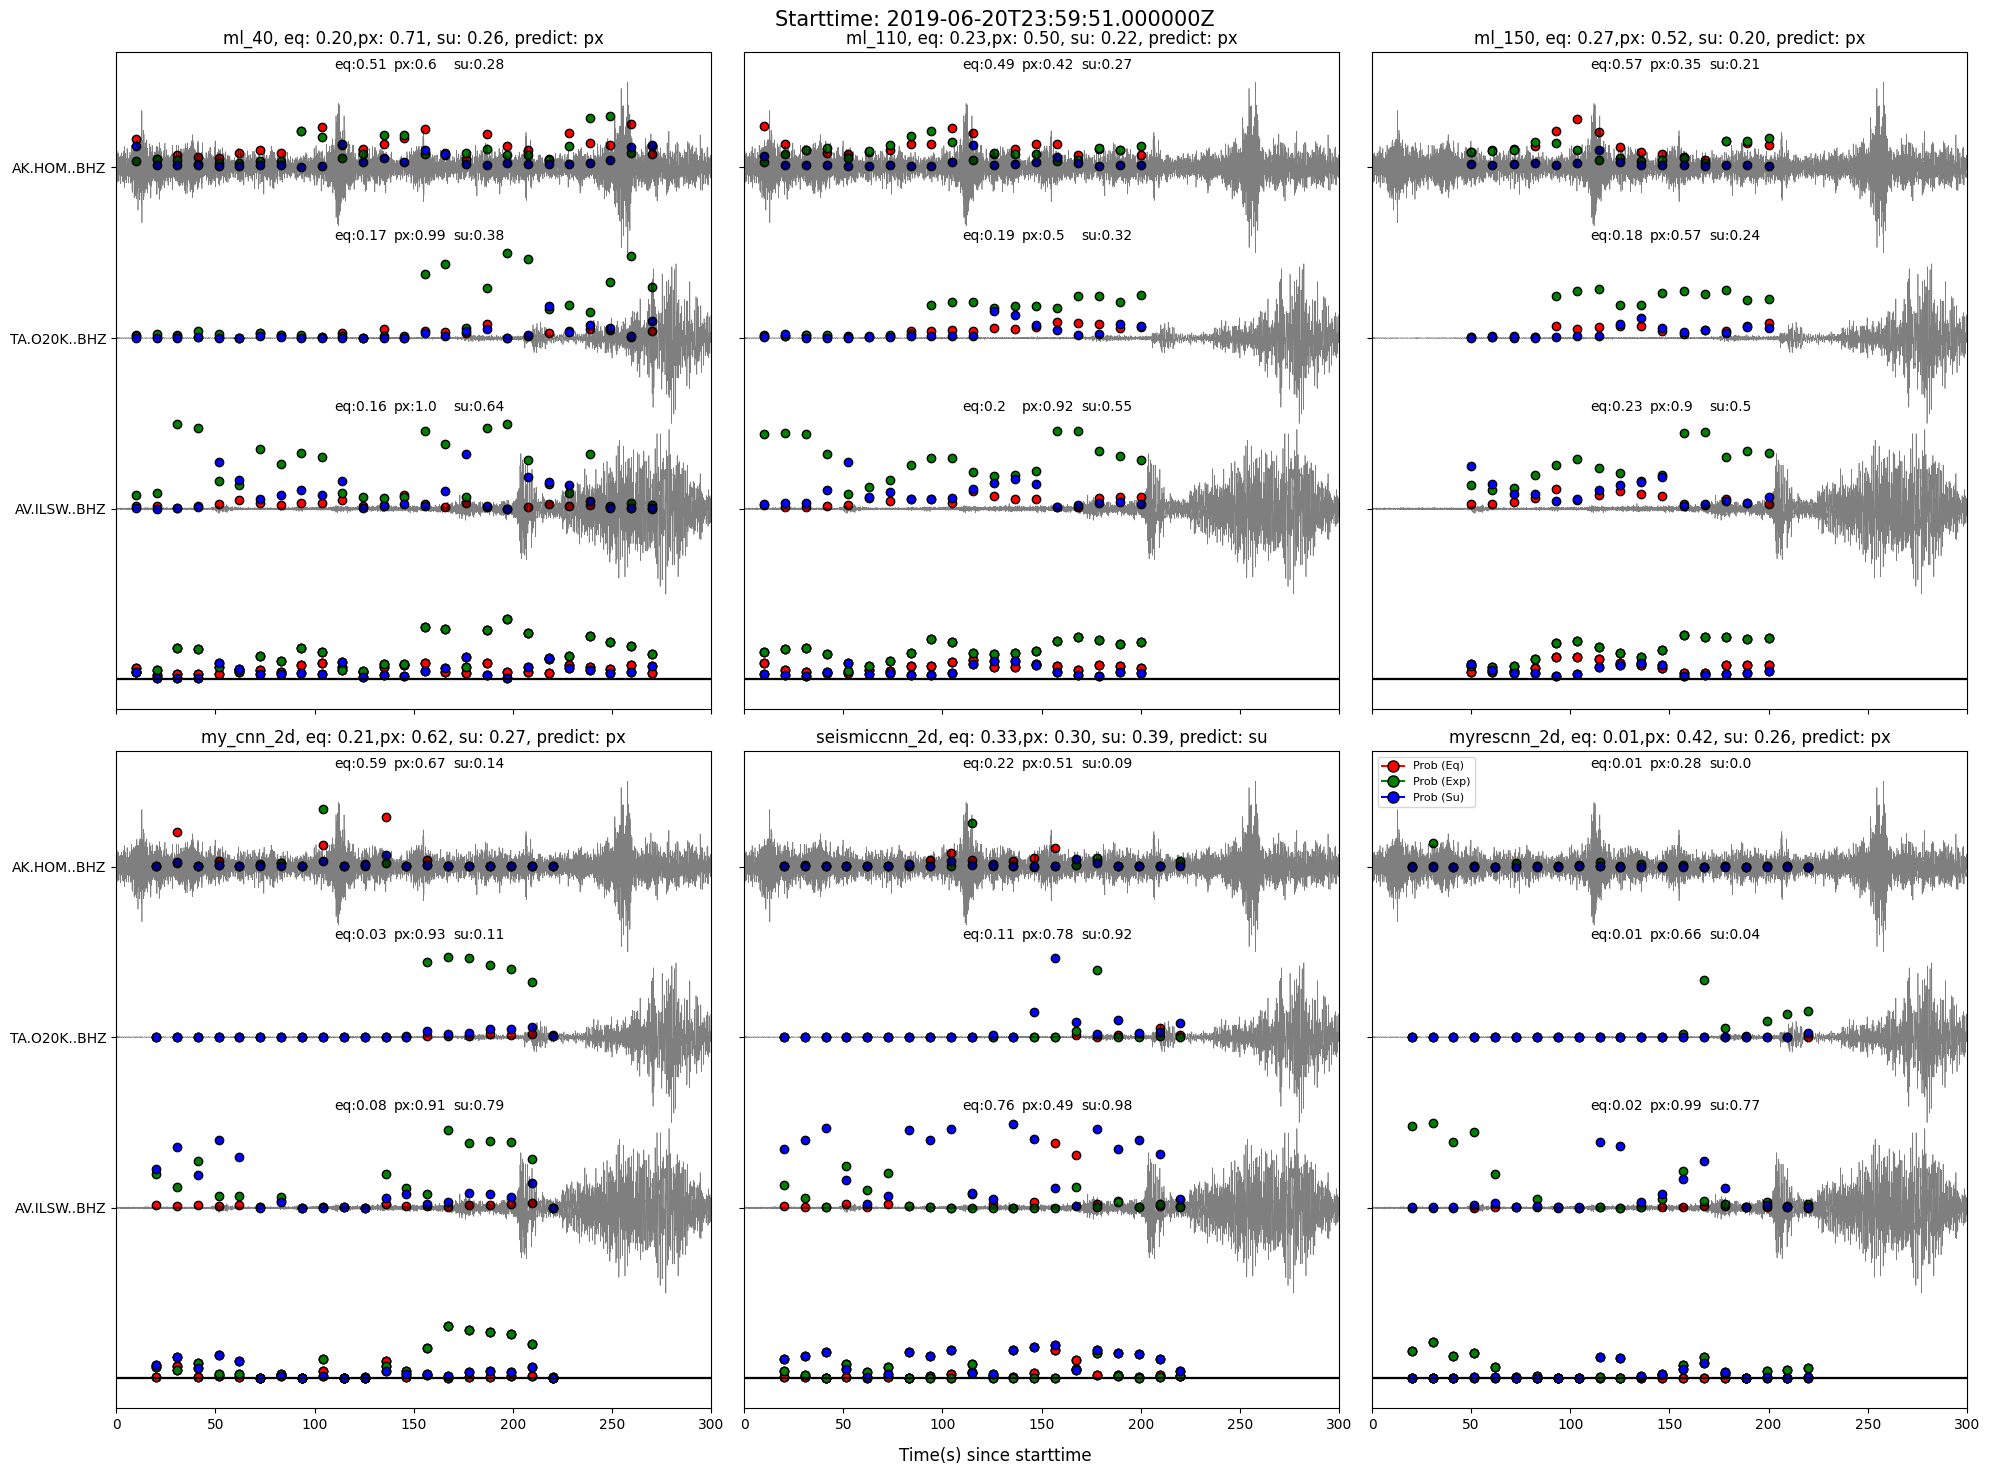

In [37]:
from all_models_classification import plot_waveform_and_probs

model_probs_dict = {'ml_40':stn_probs_ml_40, 
                  'ml_110':stn_probs_ml_110,
                  'ml_150':stn_probs_ml_150,
                  'mycnn_2d':stn_probs_mycnn_2d,
                  'seismiccnn_2d':stn_probs_seismiccnn_2d,
                  'myrescnn_2d':stn_probs_myrescnn_2d}

plot_waveform_and_probs(big_reshaped_data, 
                            model_probs_dict, 
                            start_time, end_time, orig_sr,   
                            big_station_ids, figsize=(20, 15), threshold = 0.1)

## Deleting the big downloaded files

In [38]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".joblib"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        
# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)